# Results Analysis Notebook

In [1]:
import os
import argparse
import numpy as np
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from glob import glob
from pathlib import Path
from scipy import ndimage
from scipy.stats import entropy
from skimage.transform import rescale, resize
#from scipy.misc import imresize
try:
   import rasterio
except ImportError:
   print("ERROR: Could not import Rasterio Python library.")
   print("Check if Rasterio is installed.")

In [5]:
# Senegal dataset
data_regex = '/explore/nobackup/projects/ilab/projects/srlite/input/Howland/*_M1BS_*-toa.tif'
chm_regex = '/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/output/howland/*.tif'

# Howland dataset
#data_regex = ''
#chm_regex = ''

# Serc dataset
#data_regex = ''
#chm_regex = ''

In [6]:
# extract files and store in list
data_filenames = glob(data_regex)
chm_filenames = glob(chm_regex)
print(f"{len(data_filenames)} data filenames, {len(chm_filenames)} chm filenames")

12 data filenames, 4 chm filenames


/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/output/howland/WV02_20180529_M1BS_103001007AADCE00-toa.2m_chm.tif


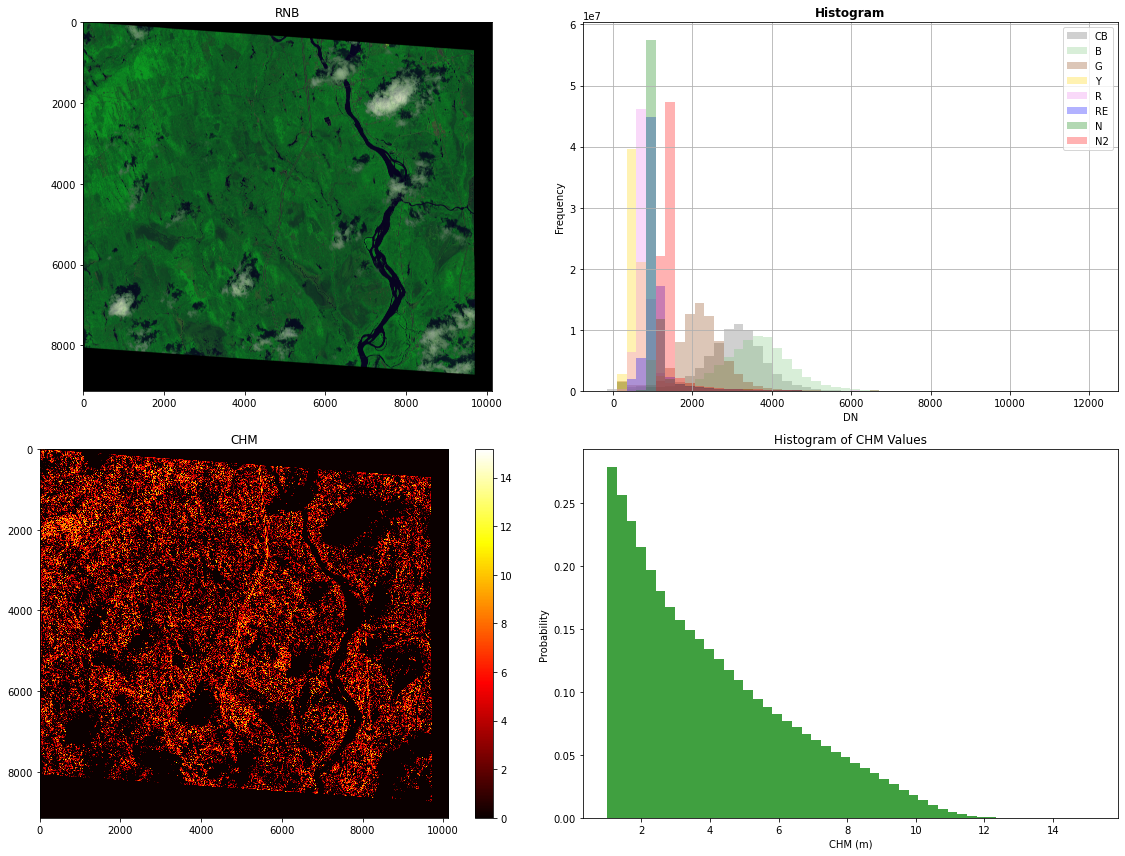

/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/output/howland/WV02_20160322_M1BS_1030010052466F00-toa.2m_chm.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


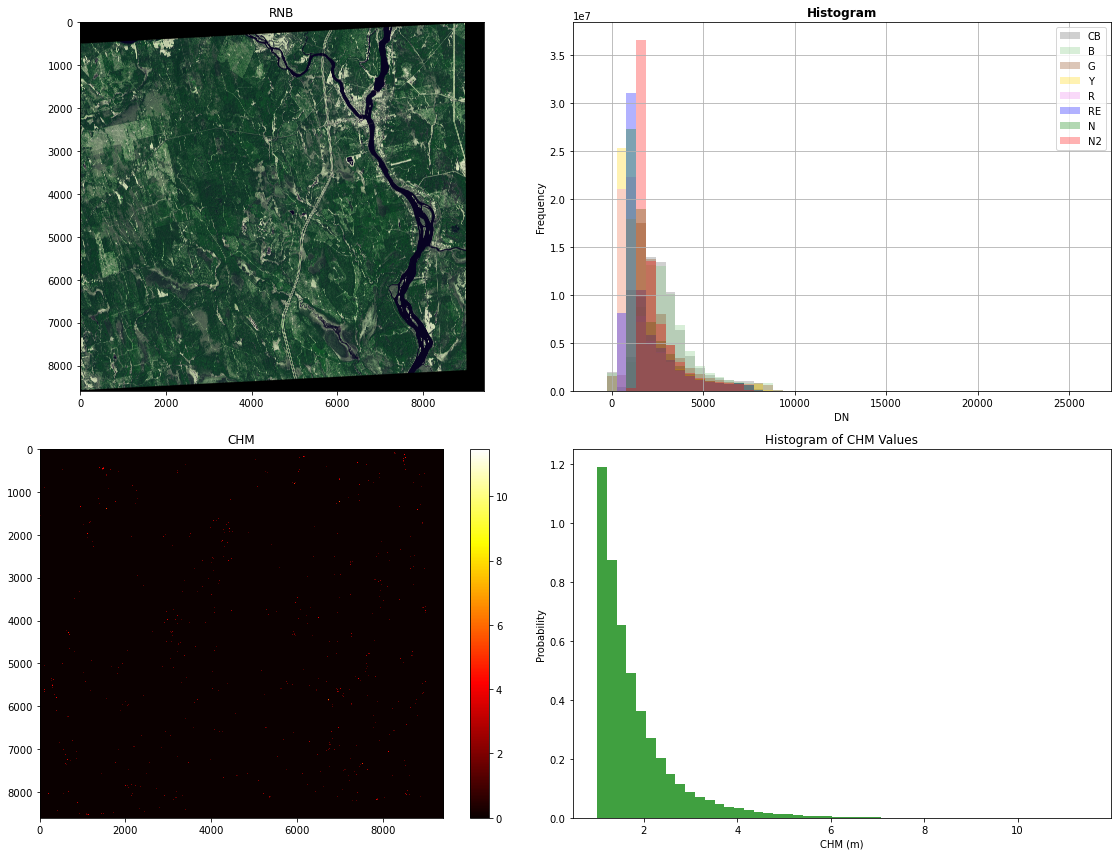

/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/output/howland/WV02_20160114_M1BS_1030010050497600-toa.2m_chm.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


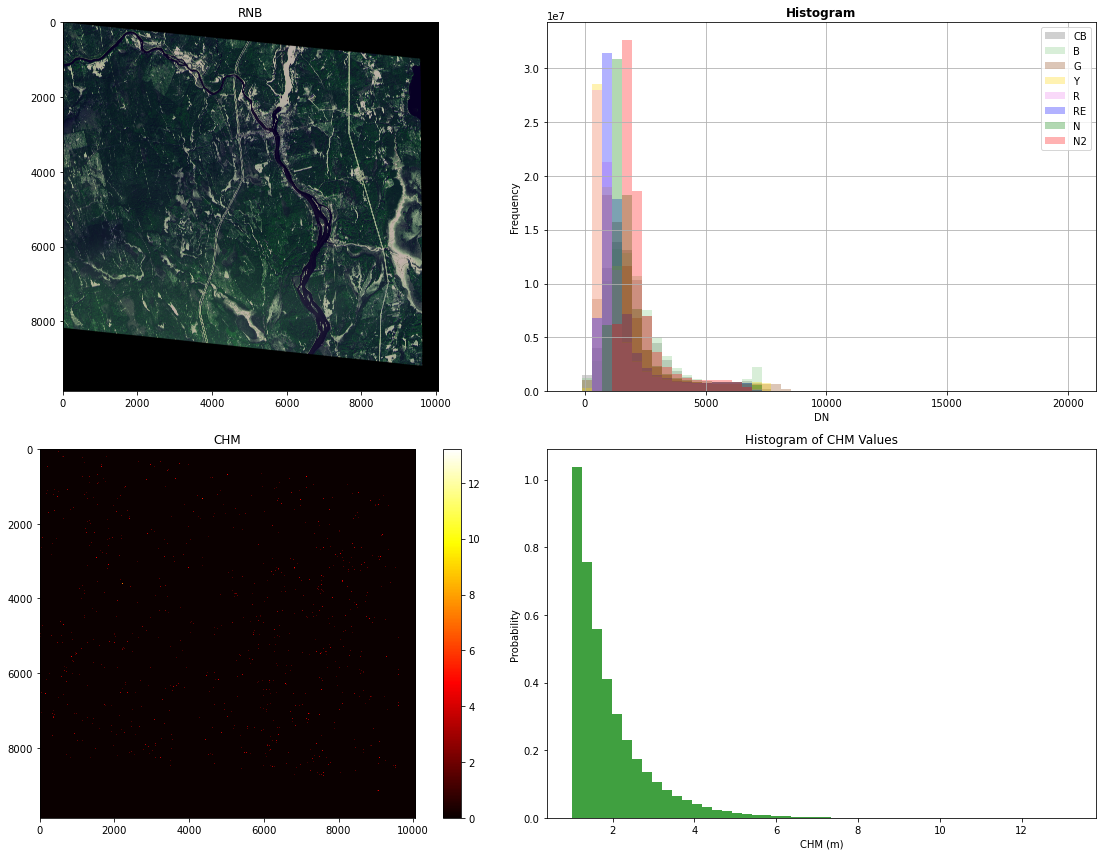

/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/output/howland/GE01_20100422_M1BS_1050410001CDE500-toa.2m_chm.tif


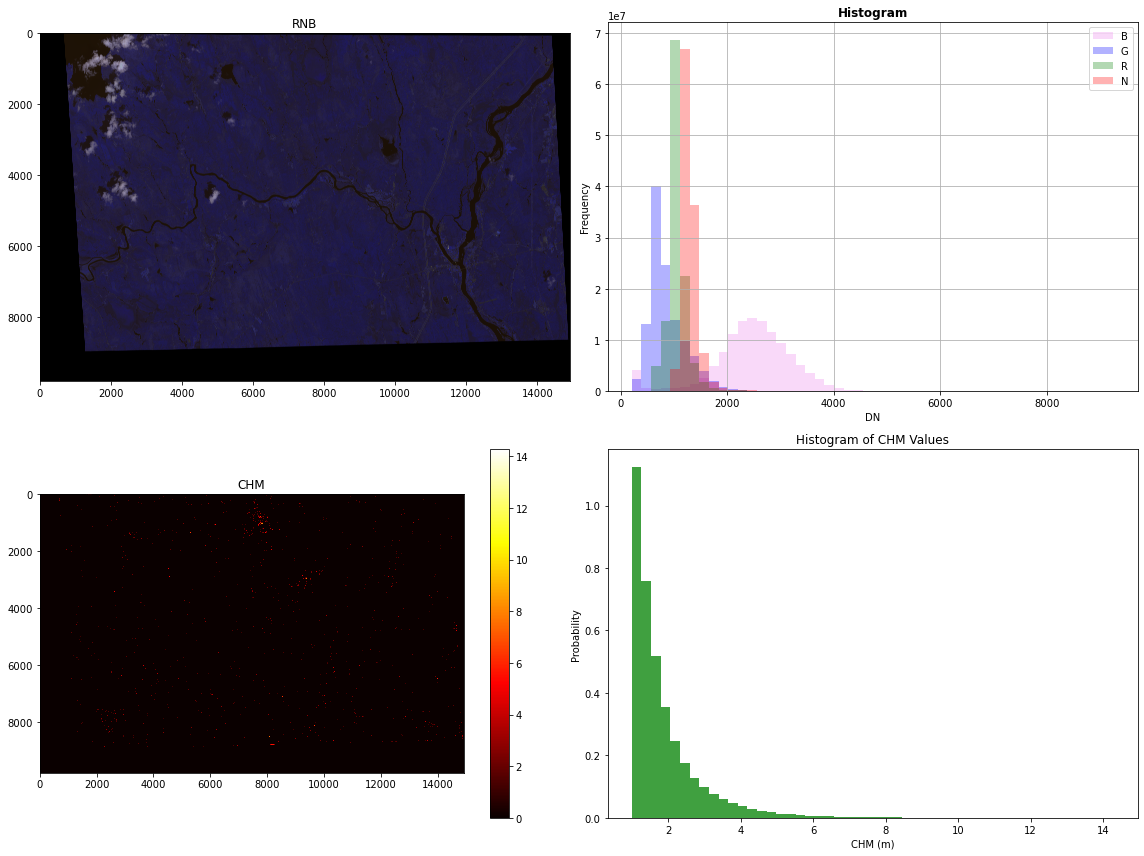

In [9]:
for chm_filename in chm_filenames:

    print(chm_filename)

    # get corresponding data filename
    data_filename = os.path.join(
        Path(data_regex).parent.absolute(),
        f"{Path(Path(chm_filename).stem).stem}.tif"
    )
    
    # open filenames
    src_data = rasterio.open(data_filename)
    src_chm = rasterio.open(chm_filename)
    src_chm = src_chm.read()
    src_chm[src_chm < 1] = 0
    src_chm[src_chm >= 255] = 0
    
    try:
        src_data_clean = src_data.read((5,7,1))
        rgb_legend = ["CB", "B", "G", "Y", "R", "RE", "N", "N2"]
    except IndexError:
        # deal with 4-band imagery
        src_data_clean = src_data.read((1,2,4))
        rgb_legend = ["B", "G", "R", "N"]
    
    src_data_clean[src_data_clean < 0] = 0

    fig, axs = plt.subplots(2, 2, figsize=(16,12))
    
    x = np.linspace(0, 2 * np.pi, 400)
    y = np.sin(x ** 2)

    # rgb image
    show(src_data_clean / 10000.0, ax=axs[0, 0])
    axs[0, 0].set_title("RNB")
    
    # chm image
    #show(src_chm, ax=axs[1, 0], cmap='viridis')
    im = axs[1, 0].imshow(np.squeeze(src_chm), cmap='hot', interpolation='nearest')
    axs[1, 0].set_title("CHM")
    plt.colorbar(im, ax=axs[1, 0])
    
    # rgb histogram
    #axs[0, 1].plot(x + 1, y + 1)
    #axs[0, 1].set_title("unrelated")
    show_hist(
        src_data, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', ax=axs[0, 1])
    axs[0, 1].legend(rgb_legend,loc="upper right")
    
    # chm histogram
    src_chm = np.squeeze(src_chm).flatten()
    src_chm[src_chm < 1] = 0
    src_chm[src_chm > 255] = 0
    src_chm = np.delete(src_chm, np.where(src_chm == 0))
    src_chm = np.delete(src_chm, np.where(src_chm == 255))
    
    axs[1, 1].hist(np.squeeze(src_chm), 50, density=True, facecolor='g', alpha=0.75)
    axs[1, 1].set_xlabel('CHM (m)')
    axs[1, 1].set_ylabel('Probability')
    axs[1, 1].set_title('Histogram of CHM Values')

    fig.tight_layout()
    plt.show()
